# House pricing on the basis of square footage and realtor assesment

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

In [173]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

from datetime import datetime

import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

## Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records

In [174]:
df = pd.read_csv("kc_house_data.csv")
df.head()
print("Columns: \n",df.columns,'\n')
print("Data count =",len(df),'\n')

# Sort dataset by date
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by='date', inplace=True)

print(df)

Columns: 
 Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object') 

Data count = 21613 

               id       date      price  bedrooms  bathrooms  sqft_living  \
16768  5561000190 2014-05-02   437500.0         3       2.25         1970   
9596    472000620 2014-05-02   790000.0         3       2.50         2600   
9587   1024069009 2014-05-02   675000.0         5       2.50         2820   
20602  7853361370 2014-05-02   555000.0         4       2.50         3310   
11577  5056500260 2014-05-02   440000.0         4       2.25         2160   
...           ...        ...        ...       ...        ...          ...   
7898   1422700040 2015-05-14   183000.0         3       1.00         1170   
928    8730000270 2015-05-14   359000.0         2     

In [175]:
df_front = df.iloc[:1000]
df = df.iloc[-1000:]

print(df_front['date'].min(), df_front['date'].max())
print(df['date'].min(), df['date'].max())

2014-05-02 00:00:00 2014-05-20 00:00:00
2015-04-27 00:00:00 2015-05-27 00:00:00


As we can see our data consits of 21613 records from 02-05-2014 up to 27-05-2015. howewer for sake of our discuionn we will first analyze first 1000 samples, date between(2014-05-02 and 2014-05-20) samples to obtain Prior and then compute posterior for last 1000 samples whitch are from dates 2015-04-27 up to 2015-05-27

## Model 1

### Prior

The parameters for the prior have been selected on the basis of a linear regression with a variance . (do dokończenia idk czy linear regression)

The prior has is fed 

Line fit:  
246.5 x + 2.459e+04


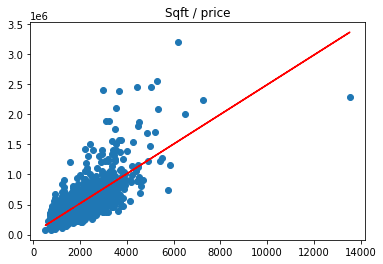

In [176]:
p = np.poly1d(np.polyfit(df_front['sqft_living'], df_front["price"], 1))
print(f"Line fit: {p}")

line = p(df_front['sqft_living'])
plt.scatter(df_front['sqft_living'], df_front["price"])
plt.plot(df_front['sqft_living'],line, "r-")
plt.title("Sqft / price")
plt.show()


In [177]:
# grade_linspace = np.linspace(df_front['grade'].min(),df['grade'].max())

# data = {'N': len(sqft_linspace),
#         'sqft': sqft_linspace,
#         'grade': grade_linspace}
# two_params_ppc = CmdStanModel(stan_file='two_params_ppc.stan')
# two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

# sqft_linspace = np.linspace(df_front['sqft_living'].min(),df_front['sqft_living'].max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}
one_param_ppc_a = CmdStanModel(stan_file='one_param_ppc_a.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [178]:
df_front['sqft_living'].max()

13540

In [179]:
one_param_ppc_a_simulated.summary().head()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
alpha,-10.0,78.0,2500.0,-4300.0,60.0,4200.0,1100.0,23000.0,1.0
beta,240.0,4.9,150.0,2.8,240.0,500.0,930.0,20000.0,1.0
sigma,350.0,13.0,330.0,20.0,250.0,1100.0,710.0,15000.0,1.0
price[1],127070.0,2572.0,78549.0,-1189.0,125162.0,257575.0,933.0,19843.0,1.0


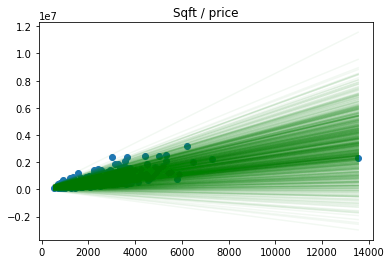

In [180]:
prices_sim=one_param_ppc_a_simulated.stan_variable('price')
for i in range(0,len(df_front['sqft_living'])):
    plt.plot(sqft_linspace, prices_sim[i], color="g",alpha=0.05)

plt.scatter(df_front['sqft_living'], df_front["price"])

plt.title("Sqft / price")
plt.show()

In [181]:
sqft_linspace = np.linspace(df_front['sqft_living'].min(),df_front['sqft_living'].max())


data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}
one_param_ppc_b = CmdStanModel(stan_file='one_param_ppc_b.stan')
one_param_ppc_b_simulated = one_param_ppc_b.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


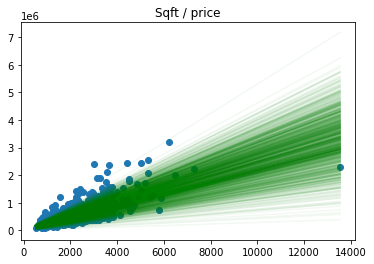

In [182]:
prices_sim=one_param_ppc_b_simulated.stan_variable('price')

for i in range(0,len(df_front['sqft_living'])):
    plt.plot(sqft_linspace, prices_sim[i], color="g",alpha=0.05)

plt.scatter(df_front['sqft_living'], df_front["price"])

plt.title("Sqft / price")
plt.show()

## Model 1 Posterior

In [183]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'price': df['price']}
one_param = CmdStanModel(stan_file='one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


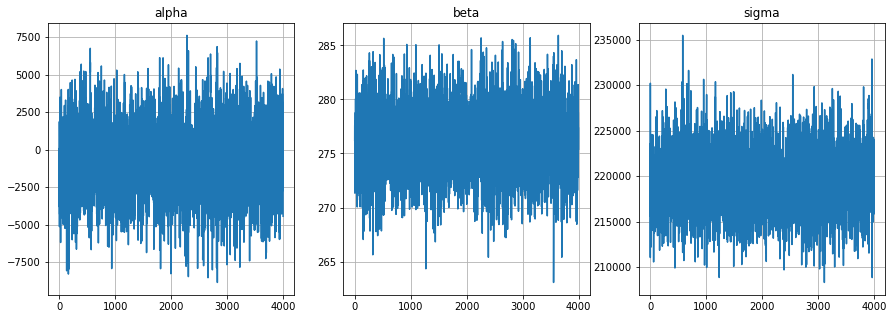

,mean,sd,hdi_3%,hdi_97%
alpha,-704.37,2431.36,-5165.70,3935.67
beta,276.09,3.23,270.25,282.45
sigma,219309.77,3474.93,213219.00,226276.00


In [199]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].plot(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].plot(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].plot(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

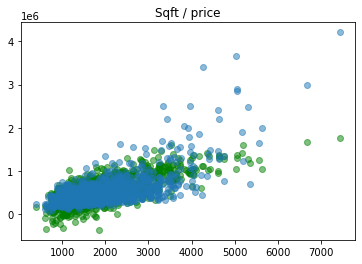

In [185]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
plt.scatter(df['sqft_living'], prices_sim[1], color="g", alpha=0.5)

plt.scatter(df['sqft_living'], df["price"], alpha=0.5)

plt.title("Sqft / price")
plt.show()

## Adding second predictor to model

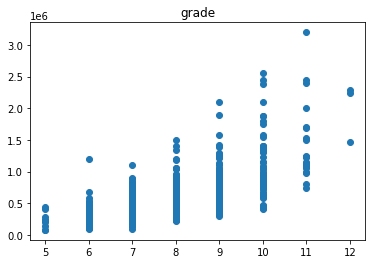

In [186]:
plt.scatter(df_front['grade'], df_front["price"])
plt.title("grade")
plt.show()

In [187]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm


X = df_front[['sqft_living', 'grade']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df_front['price']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -589411.4025763632
Coefficients: 
 [   153.50498167 104795.72869447]


### Prior predictive check

In [188]:
sqft_linspace = np.linspace(df_front['sqft_living'].min(),df_front['sqft_living'].max())
grade_linspace = np.linspace(df_front['grade'].min(),df_front['grade'].max())

data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace,
        'grade': grade_linspace}
two_params_ppc = CmdStanModel(stan_file='two_params_ppc.stan')
two_params_ppc_simulated = two_params_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


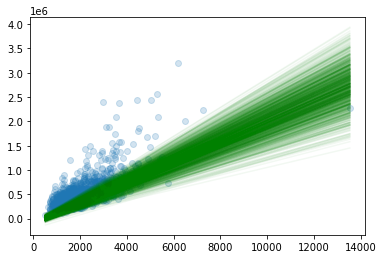

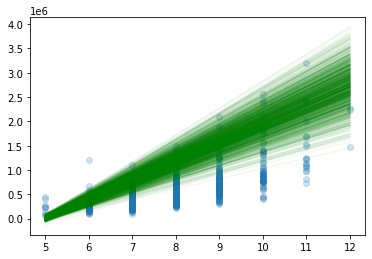

In [189]:
prices_sim=two_params_ppc_simulated.stan_variable('price')

plt.scatter(df_front['sqft_living'],df_front['price'],alpha=0.2)
for i in range(0,len(df_front['sqft_living'])):
    plt.plot(sqft_linspace, prices_sim[i], color="g", alpha=0.05)
plt.show()


for i in range(0,len(df_front['sqft_living'])):
    plt.plot(grade_linspace, prices_sim[i], color="g", alpha=0.05)

plt.scatter(df_front['grade'],df_front['price'] ,alpha=0.2)



In [190]:
data = {'N': len(df['sqft_living']),
        'sqft_living': df['sqft_living'],
        'grade': df['grade'],
        'price': df['price']}
two_params = CmdStanModel(stan_file='two_params.stan')
two_params_simulated = two_params.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)





chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:07 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:08 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:09 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:10 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |███████▋  | 00:10 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:11 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:11 Itera


INFO:cmdstanpy:CmdStan done processing.


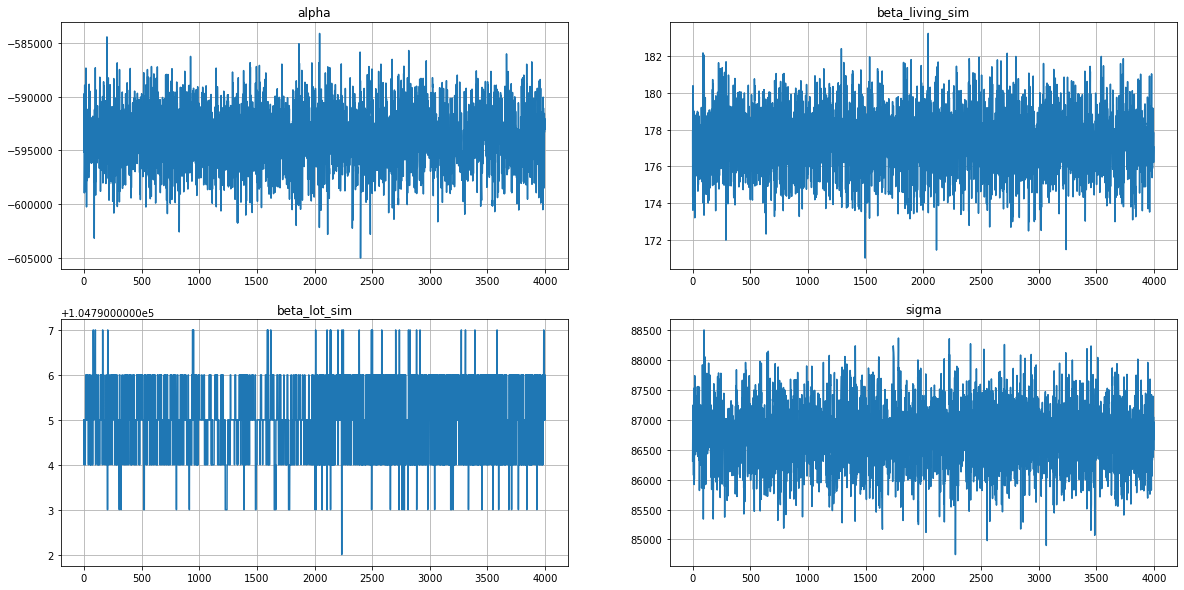

In [198]:
alpha_sim = two_params_simulated.stan_variable('alpha')
beta_living_sim = two_params_simulated.stan_variable('beta_sqft_living')
beta_lot_sim = two_params_simulated.stan_variable('beta_grade')
sigma_sim = two_params_simulated.stan_variable('sigma')
price_sim = two_params_simulated.stan_variable('prices')

fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 10)
axs[0][0].plot(alpha_sim)
axs[0][0].grid()
axs[0][0].set_title('alpha')
axs[0][1].plot(beta_living_sim)
axs[0][1].grid()
axs[0][1].set_title('beta_living_sim')
axs[1][0].plot(beta_lot_sim)
axs[1][0].grid()
axs[1][0].set_title('beta_lot_sim')
axs[1][1].plot(sigma_sim)
axs[1][1].grid()
axs[1][1].set_title('sigma')
plt.show()


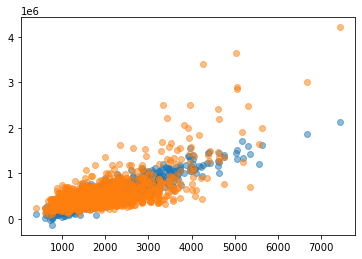

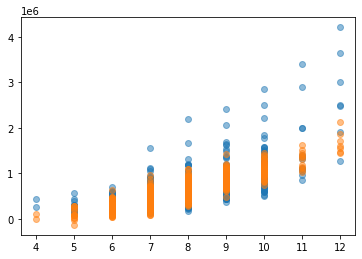

In [200]:
price_sim = two_params_simulated.stan_variable('prices')


plt.scatter(df['sqft_living'],price_sim[0], alpha=0.5)
plt.scatter(df['sqft_living'],df['price'], alpha=0.5)
plt.show()

plt.scatter(df['grade'],df['price'], alpha=0.5)
plt.scatter(df['grade'],price_sim[0], alpha=0.5)


In [201]:
# Comparing 2 models: model_1 - with AGE only, model_2 - with AGE and BMI
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = two_params_simulated, log_likelihood = "log_lik") 
compare_dict = {"one_param_model": idata1, "two_param_model": idata2}

out_loo = az.compare(compare_dict, ic = "loo")
out_waic = az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
one_param_model,0,-14053.745473,16.662970,0.000000,0.854099,109.339078,0.000000,True,log
two_param_model,1,-17172.214505,87.472285,3118.469032,0.145901,644.575802,537.218138,True,log


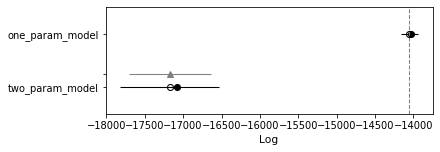

In [202]:
az.plot_compare(out_loo)
out_loo


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
one_param_model,0,-14053.561520,16.479018,0.000000,0.854099,109.256714,0.000000,True,log
two_param_model,1,-17183.616184,98.873964,3130.054664,0.145901,649.939270,542.697031,True,log


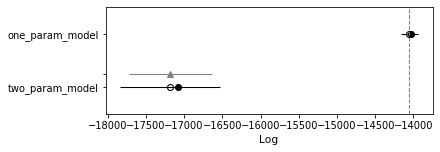

In [203]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.